In [1]:
import caffe
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np

In [3]:
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [4]:
caffe.set_mode_gpu()
caffe.set_device(0)

In [5]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [6]:
def get_max_xy(data):
    h = data.shape[0]
    w = data.shape[1]
    idx = data.ravel().argmax()
    return idx/w,idx%w

In [9]:
model_def = 'PSConv_lenet_train_test.prototxt'
model_weights = 'PSConv/PSConv_lenet__iter_20000.caffemodel'


def get_net(model_def,model_weights,display=True):
    model_def = os.path.abspath(model_def)
    model_weights = os.path.abspath(model_weights)

    net = caffe.Net(model_def,model_weights,caffe.TEST)
    net.forward()
    if display:
        for layer_name,blob in net.blobs.iteritems():
            print layer_name + '\t' + str(blob.data.shape)
    return net

In [10]:
net3 = get_net(model_def,model_weights)

data	(100, 1, 28, 28)
label	(100,)
label_mnist_1_split_0	(100,)
label_mnist_1_split_1	(100,)
conv1	(100, 90, 28, 28)
pool1	(100, 90, 14, 14)
conv2	(100, 180, 14, 14)
conv3	(100, 360, 14, 14)
conv4	(100, 360, 7, 7)
conv5	(100, 10, 5, 5)
pool	(100, 10, 1, 1)
pool_pool_0_split_0	(100, 10, 1, 1)
pool_pool_0_split_1	(100, 10, 1, 1)
accuracy	()
loss	()


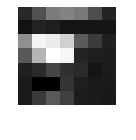

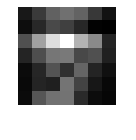

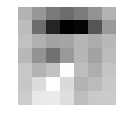

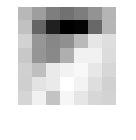

In [29]:
img_idx = 0
cls_idx = 7
layer_name = 'conv5'
help_function(layer_name,img_idx,cls_idx,net3)

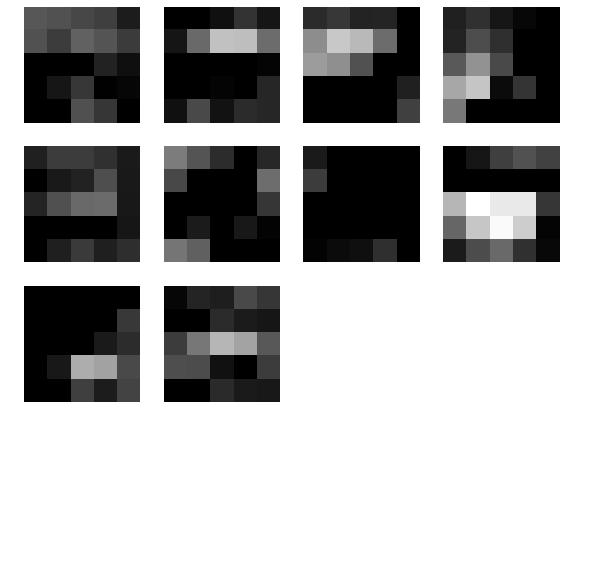

In [28]:
vis_square(net3.blobs['conv5'].data[0,:])

In [18]:
model_def = 'Conv_lenet_train_test.prototxt'
model_weights = 'Conv/Conv_lenet__iter_20000.caffemodel'
net4 = get_net(model_def,model_weights)


data	(100, 1, 28, 28)
label	(100,)
label_mnist_1_split_0	(100,)
label_mnist_1_split_1	(100,)
conv1	(100, 90, 28, 28)
pool1	(100, 90, 14, 14)
conv2	(100, 180, 14, 14)
conv3	(100, 360, 14, 14)
conv4	(100, 360, 7, 7)
conv5	(100, 10, 5, 5)
pool	(100, 10, 1, 1)
pool_pool_0_split_0	(100, 10, 1, 1)
pool_pool_0_split_1	(100, 10, 1, 1)
accuracy	()
loss	()


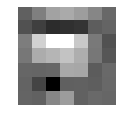

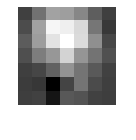

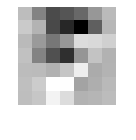

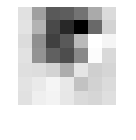

In [26]:
help_function(layer_name,img_idx,cls_idx,net4)

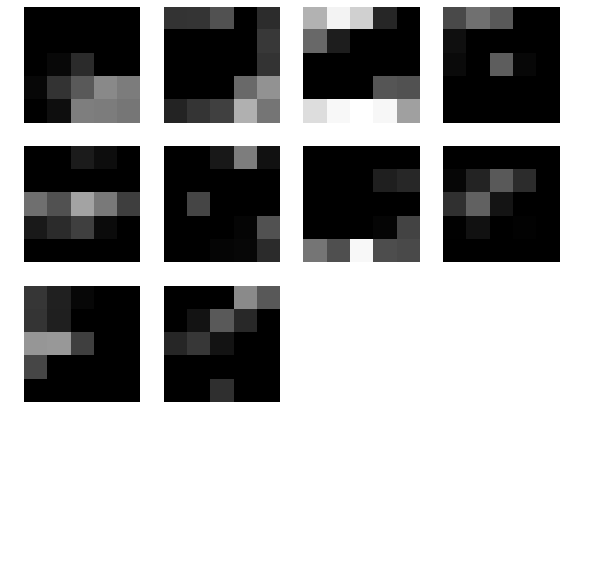

In [19]:
vis_square(net4.blobs['conv5'].data[0,:])

In [23]:
def get_feat_g(layer_name,
               img_idx,
               cls_idx,
               net,
               kernel_spatial_idx,
               group_idx=None,
               display=True):
    
    
    
    layer = net.layer_dict[layer_name]
    
    num_classes = layer.blobs[0].data.shape[0]
    assert cls_idx <num_classes,\
    'cls_idx is out of range,it should be between (0,{:d})'.format(num_classes-1)

    filters_cls = layer.blobs[0].data[cls_idx]
    bias_cls = layer.blobs[1].data[cls_idx]
    
#     filter param
    kernel_in_channels = filters_cls.shape[0]
    kernel_space_dim = filters_cls.shape[-1]*filters_cls.shape[-2]
    
#     bottom data param
    bottom_name = net.bottom_names[layer_name][0] 
    bottom_shape = net.blobs[bottom_name].data.shape
    
    batch_size = bottom_shape[0]
    in_channels = bottom_shape[1]
    height = bottom_shape[2]
    width = bottom_shape[3]
    
    assert img_idx<batch_size,\
    'img_idx is out of range,it should be between (0,{:d})'.format(batch_size-1)
    
#     so infer ps_group
    assert in_channels%kernel_in_channels==0,'filter shape error'
    ps_group = in_channels/kernel_in_channels
    
    
    
#    check if use all in channels or ps_group channels
    if kernel_space_dim==ps_group:
        ps=True
        group_idx = kernel_spatial_idx
    else:
        ps=False
#         print 'you are fool'
        assert ps_group==1, 'just support ps_group=1 now'
        group_idx = 0
    
    assert group_idx is not None,'group_idx must be specific in normal model'
    assert group_idx<ps_group,\
    'group_idx is out of range, it should be between (0,{:d})'.format(ps_group-1)
    
    conv_g = net.blobs[bottom_name]\
    .data[img_idx,kernel_in_channels*group_idx:kernel_in_channels*(group_idx+1)]

    conv_g_reshaped = conv_g.reshape((kernel_in_channels,-1))
    filters_cls = filters_cls.reshape((kernel_in_channels,-1))
    if ps:
        filters_cls_g = filters_cls[:,group_idx]
    else:
        assert kernel_spatial_idx is not None,\
        'kernel_spatial_idx must be specific in normal model'
        filters_cls_g = filters_cls[:,kernel_spatial_idx]

    filters_cls_g_reshaped = filters_cls_g.reshape((1,-1))
    conv_cls_g = filters_cls_g_reshaped.dot(conv_g_reshaped)+bias_cls
    
    conv_cls_g_reshaped = conv_cls_g.reshape((1,height,width))
#     print height
    if display:
        plt.figure(figsize=(2, 2))
        vis_square(conv_cls_g_reshaped)
    return conv_cls_g_reshaped

In [14]:
def help_function(layer_name,img_idx,cls_idx,net):
    weight_shape = net.layer_dict[layer_name].blobs[0].data[cls_idx].shape
    kernel_spatial_dim = weight_shape[-1] * weight_shape[-1]
    for kernel_spatial_idx in range(kernel_spatial_dim):
        get_feat_g(layer_name,img_idx,cls_idx,net,kernel_spatial_idx)

In [452]:

def convert_out2in(spatial_center,kernel_spatial,pad,stride,dilation=1):

    out_h_idx = spatial_center[0]
    out_w_idx = spatial_center[1]
    in_h_idx = out_h_idx*stride-pad+kernel_spatial[0]*dilation
    in_w_idx = out_w_idx*stride-pad+kernel_spatial[1]*dilation
    return in_h_idx,in_w_idx
# arg: center is 3D like (c,h,w)
def  get_next_layer_max_xy(net,
                           layer_name,
                           center,
                           image_idx,
                           
                           pad=0,
                           stride=1,
                           dilation=2,ps=True):
    layer = net.layer_dict[layer_name]
    bottom_name = net.bottom_names[layer_name][0]
#     shape: (c,h,w)
    data = net.blobs[bottom_name].data[image_idx]
    in_c = data.shape[0]
    in_h = data.shape[1]
    in_w = data.shape[2]
#     params
    weights = layer.blobs[0].data
#     print weights.shape
    bias = layer.blobs[1].data
#     print weights.shape
    h = weights.shape[-2]
    w = weights.shape[-1]
    kernel_spatial_dim = h*w
#     print kernel_spatial_dim
    out_c_idx = center[0]
    out_h_idx = center[1]
    out_w_idx = center[2]
    
    weights_sliced = weights[out_c_idx]
    res = []
    for kernel_spatial_idx in range(kernel_spatial_dim):
        max_activate_position = []
        if ps:
            assert in_c%kernel_spatial_dim==0,'input channel is not correct'
            in_c_per_g = in_c/kernel_spatial_dim
            data_sliced=data[in_c_per_g*kernel_spatial_idx:in_c_per_g*(kernel_spatial_idx+1)]
        else:
            data_sliced = data
        kernel_spatial = (kernel_spatial_idx/w,kernel_spatial_idx%w)
#         print kernel_spatial
        in_spatial = convert_out2in(center[1:],
                                    kernel_spatial,
                                    pad,
                                    stride,
                                    dilation)
#         print in_spatial
        scores = weights_sliced[:,kernel_spatial_idx/w,kernel_spatial_idx%w]*\
        data_sliced[:,in_spatial[0],in_spatial[1]]
        in_c_idx = scores.argmax()
        if ps:
            in_c_idx = in_c_per_g*kernel_spatial_idx+in_c_idx
        max_activate_position.append(in_c_idx)
        max_activate_position+=list(in_spatial)
        res.append(max_activate_position)
    return res

In [461]:
out_c_idx = 7
center = []
center.append(out_c_idx)
center+=list(get_max_xy(net3.blobs['conv5'].data[0,7]))
# print center
next_activated_points = get_next_layer_max_xy(net3,'conv5',center,0)
# print next_activated_points

In [462]:
def mapping2origial(activated_points,feat_map_size,origial_map_size):
    scale = np.array(origial_map_size).astype(np.float)/np.array(feat_map_size)
    return np.array(activated_points)[:,1:]*scale

def vis_max_activate_point(net,activated_points,pixel_val=0.5):
#     note that activated points is 2D (h,w)
    data = net.blobs['data'].data[0].copy()
    activated_points = list(activated_points)
    for origial_activated_point in activated_points:
#         print np.ceil(origial_activated_point[0])
        data[:,np.ceil(origial_activated_point[0]).astype(np.int),np.ceil(origial_activated_point[1]).astype(np.int)]=pixel_val
    vis_square(data)

In [463]:
def normalize(all_scores,type='relu'):
    _sum = 0
    all_proportion = []
    for idx,score in enumerate(all_scores):
        if score<0 and type=='relu':
            all_scores[idx] = 0
            continue
        _sum += score
    for score in all_scores:
        all_proportion.append(1.0*score/_sum)
    return all_proportion

def get_part_proportion(layer_name,
                        center,
                        net,
                        image_idx=0,
                        pad=0,
                        stride=1,
                        dilation=1,
                        ps=True):
    next_activated_points = get_next_layer_max_xy(net,
                                                  layer_name,
                                                  center,
                                                  image_idx,
                                                  pad,
                                                  stride,
                                                  dilation,
                                                 ps)
    all_scores = []
    layer = net.layer_dict[layer_name]
#     params
    weights = layer.blobs[0].data
    h = weights.shape[-2]
    w = weights.shape[-1]
    kernel_spatial_dim = h*w
    cls_idx = center[0]
    for kernel_spatial_idx in range(kernel_spatial_dim):
        conv_cls_g_reshaped = get_feat_g(layer_name,
                   image_idx,
                   cls_idx,
                   net,
                   kernel_spatial_idx,
                   kernel_spatial_idx,
                   False)
        next_activated_point = next_activated_points[kernel_spatial_idx]
        all_scores.append(conv_cls_g_reshaped[0,next_activated_point[-2],next_activated_point[-1]])
    return normalize(all_scores),all_scores

In [464]:
feat_map_size = net3.blobs['conv4'].data.shape[2:]
origial_map_size = net3.blobs['data'].data.shape[2:]
origial_activated_points = mapping2origial(next_activated_points,
                feat_map_size,
                origial_map_size)
# print origial_activated_points

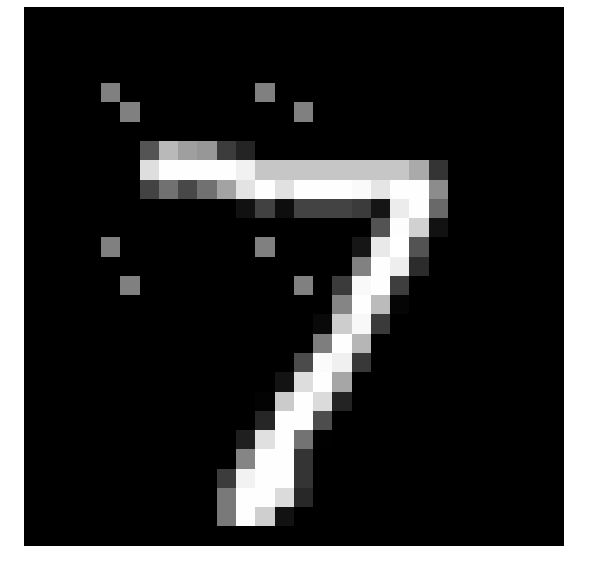

In [465]:
vis_max_activate_point(net3,origial_activated_points)

In [466]:
pad = 0
stride = 2
dilation = 1
for next_activated_point in next_activated_points:
    print get_next_layer_max_xy(net3,'conv4',next_activated_point,0,pad,stride,dilation)

[[88, 2, 2], [119, 2, 3], [260, 3, 2], [342, 3, 3]]
[[88, 2, 6], [119, 2, 7], [225, 3, 6], [342, 3, 7]]
[[12, 6, 2], [152, 6, 3], [210, 7, 2], [357, 7, 3]]
[[25, 6, 6], [135, 6, 7], [237, 7, 6], [339, 7, 7]]


In [467]:
print next_activated_points

[[79, 1, 1], [128, 1, 3], [262, 3, 1], [332, 3, 3]]


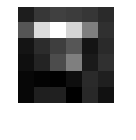

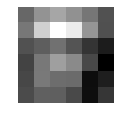

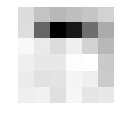

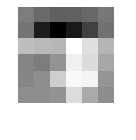

In [468]:
help_function('conv5',0,7,net3)

In [469]:

all_proportion,all_scores = get_part_proportion('conv5',
                        center,
                        net3,
                        image_idx=0,
                        pad=0,
                        stride=1,
                        dilation=2,
                        ps=True)
print all_proportion
print sum(all_scores)

[0.59833373199915696, 0.25482738991426895, 0.0, 0.14683887808657409]
52.0455303192


In [470]:
net3.blobs['conv5'].data[0,7]

array([[ 15.62751198,  21.85580635,  17.28256607,  12.94429016],
       [ 26.7072506 ,  51.04868698,  48.57373428,  35.87853241],
       [ 10.96104622,  14.31527519,  14.66806221,  11.22163963],
       [  9.51441574,  16.65514183,  12.21765232,  14.70408821]], dtype=float32)

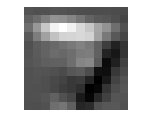

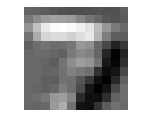

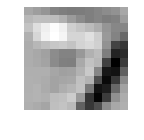

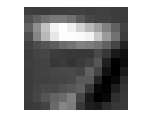

In [388]:
help_function('conv4',0,79,net3)

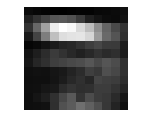

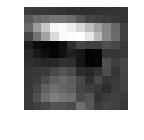

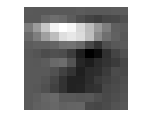

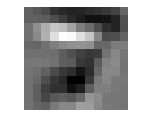

In [389]:
help_function('conv4',0,128,net3)

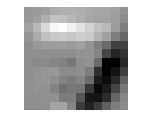

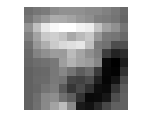

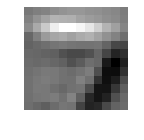

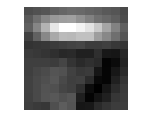

In [390]:
help_function('conv4',0,262,net3)

# another net for compasion

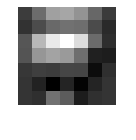

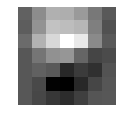

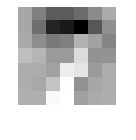

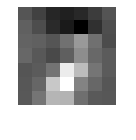

In [435]:
# net4
help_function('conv5',0,7,net4)

In [472]:
out_c_idx = 7
center = []
center.append(out_c_idx)
center+=list(get_max_xy(net4.blobs['conv5'].data[0,7]))
# print center

# print next_activated_points
all_proportion,all_scores = get_part_proportion('conv5',
                        center,
                        net4,
                        image_idx=0,
                        pad=0,
                        stride=1,
                        dilation=2,
                        ps=False)
print all_proportion
print sum(all_scores)

[0.25380054047015327, 0.42406293607607548, 0.0, 0.32213652345377125]
55.096657753


[7, 2, 1]
[[ 12.42343903  17.47160721  22.72000504  14.27887058   9.6363821 ]
 [ 15.03734303  18.44903564  22.95429802  11.95959949  11.38565254]
 [ 24.5782032   54.34946823  49.44903564  38.81349945  24.76303482]
 [ 25.13131523  38.57902908  21.59469986  19.3706913    1.37426496]
 [ 12.70007229   6.69870996   9.00494576   6.51439428   0.05453178]]


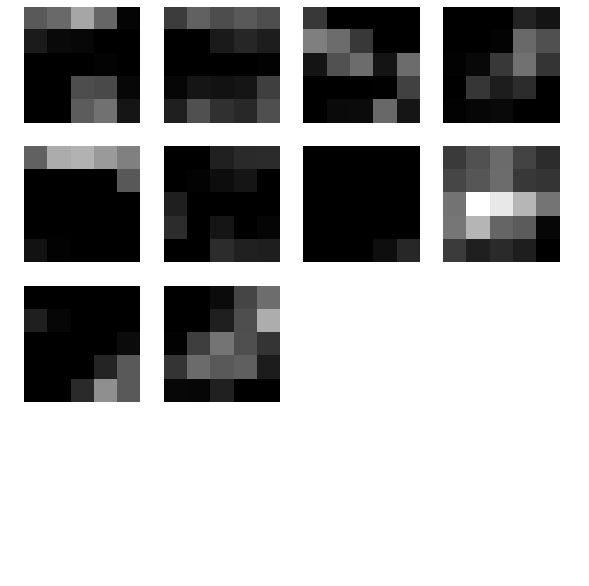

In [473]:
print center
print net4.blobs['conv5'].data[0,7]
vis_square(net4.blobs['conv5'].data[0])

In [474]:
next_activated_points_4 = get_next_layer_max_xy(net4,
                           'conv5',center,0,ps=False)
print next_activated_points_4

[[211, 2, 1], [211, 2, 3], [164, 4, 1], [214, 4, 3]]


In [477]:
def help_vis_max_activated_point(net,layer_name,next_activated_points):
#     next_activated_points = get_next_layer_max_xy(net,'conv5',center,0)
    feat_map_size = net.blobs[layer_name].data.shape[2:]
    origial_map_size = net.blobs['data'].data.shape[2:]
    origial_activated_points = mapping2origial(next_activated_points,
                    feat_map_size,
                    origial_map_size)
    vis_max_activate_point(net4,origial_activated_points)

In [ ]:
help_vis_max_activated_point(net4,'conv4',next_activated_points_4)